# Load Libraries

In [2]:
# importing packages
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
import seaborn as sns
from numpy.fft import fft, ifft, fftfreq
import scipy
from scipy import interpolate
import pandas as pd
from FWHM import FWHM
from collections import Counter
import random
from scipy.ndimage import gaussian_filter
from joblib import dump, load
import gc
import scipy.io
import h5py
from sklearn.preprocessing import MinMaxScaler
import os, sys, json
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import spikeinterface.full as si
from pathlib import Path
from scipy.interpolate import griddata
import warnings
import bisect
from matplotlib.colors import LinearSegmentedColormap
import sys
import cebra.datasets
from cebra import CEBRA
from mpl_toolkits.mplot3d import Axes3D
import torch
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import pickle
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
warnings.simplefilter("ignore")

import probeinterface as pi
from probeinterface.plotting import plot_probe
from probeinterface import Probe
import spikeinterface.preprocessing as spre
import mountainsort5 as ms5
from mountainsort5.util import create_cached_recording
from tempfile import TemporaryDirectory
from spikeinterface.core import concatenate_recordings
from spikeinterface import extractors as se

# Intan File Reader

In [ ]:
%run importrhdutilities.py

In [ ]:
directory = os.getcwd() + '/Recording_data/Mice ROSE chronic/M16/W3'
files = [f for f in os.listdir(directory) if f.endswith('.rhd')]
raw = []
stimuli = []
for file in files:
    file_path = os.path.join(directory, file)
    result, data_present = load_file(file_path)
    raw.append(result['amplifier_data'])
    stimuli.append(result['board_dig_in_data'][0])
raw_data = np.concatenate(raw, axis=1)
stim = np.concatenate(stimuli, axis=0)

In [ ]:
# Get timestamps of stimuli
fs = 20000
onsets = []
for i in range(0,len(stim_pulse)-1):
    if stim_pulse[i-1] == False and stim_pulse[i] == True:  
            onsets.append(i)  
onset_time = np.array(onsets)/fs
onset_time

# Probe Pin Mapping

In [304]:
ColorPalette = pd.read_excel( os.getcwd() + '/ColorPalettes.xlsx', engine='openpyxl')
colors = ColorPalette[['R','G','B']].values/255

In [305]:
file = os.getcwd()+'/128ch_16shank.xls'
mapping = pd.read_excel(file)
shank_no = mapping['shank']
elec_no = mapping['elec']

file = os.getcwd()+'/ROSE_16X8.xls'
coor = pd.read_excel(file)

sh = coor['shank']
el = coor['elec']
cor_x = coor['X']
cor_y = coor['Y']
cor_z = coor['Z']
pinmap = {}
pinmap_r = {}
pinmap_shank = defaultdict(list)

for ch in range(128):
    pinmap[ch] = (shank_no[ch],elec_no[ch])
    pinmap_r[(shank_no[ch],elec_no[ch])] = ch
    pinmap_shank[shank_no[ch]].append(ch)
coordinates = {}
for i in range(128):
    coordinates[sh[i],el[i]] = [cor_x[i],cor_y[i],cor_z[i]]
    cor_by_ch = []
for ch in range(128):
    cor_by_ch.append(coordinates[pinmap[ch]])
    
labels = sh
plt.figure(figsize=(5,5))
plt.scatter(cor_x, -cor_y, s = 200, color = 'steelblue')
plt.xlim([-1500,1500])
plt.ylim([-1500,1500])
for i, label in enumerate(labels):
    plt.text(cor_x[i], -cor_y[i], label)
plt.axis('off')

In [ ]:
file = os.getcwd()+'/64chROSE.xls'
mapping = pd.read_excel(file)
shank_no = mapping['shank']
elec_no = mapping['elec']

In [ ]:
file = os.getcwd()+'/3DROSE_64ch.xls'
pinmap_shank = defaultdict(list)
coor = pd.read_excel(file)
sh = coor['shank']
el = coor['elec']
cor_x = coor['X']
cor_y = coor['Y']
cor_z = coor['Z']
pinmap = {}
for ch in range(64):
    pinmap[ch] = (shank_no[ch],elec_no[ch])
    pinmap_shank[shank_no[ch]].append(ch)
coordinates = {}
for i in range(64):
    coordinates[sh[i],el[i]] = [cor_x[i],cor_y[i],cor_z[i]]

In [ ]:
labels = sh
plt.scatter(cor_x,cor_y)
for i, label in enumerate(labels):
    plt.text(cor_x[i], cor_y[i], label)
#plt.axis('off')


# Filtering

In [ ]:
# Trim data if needed
trim_start = 0
trim_end = 50
fs = 20000
raw_data_copy = raw_data_spon.copy()
raw_data_cut = raw_data_copy[:,int(trim_start*fs):int(trim_end*fs)]

In [ ]:
order = 2
low = 300
high = 6000
fs = 20000
filtered = []
b,a = signal.butter(order, [low, high], 'bp', fs=fs)
for row in raw_data_stim:
  filtered.append(signal.lfilter(b, a, row))
#filtered = np.array(filtered, dtype = 'float32')
med = np.median(filtered,axis=0)
filtered = filtered - med

del med
gc.collect()

# CSD plots

In [ ]:
def compute_csd(lfp_data, dz):

    n_channels, n_timepoints = lfp_data.shape
    csd_array = np.zeros_like(lfp_data)
    for t in range(n_timepoints):
        for ch in range(1, n_channels-1):
            csd_array[ch, t] = -1 * (lfp_data[ch+1, t]
                                     - 2 * lfp_data[ch, t]
                                     + lfp_data[ch-1, t]) / (dz**2)
    return csd_array  

In [ ]:
def compute_2d_csd(chan_coords, voltages, nx=50, ny=50):
    x_min, x_max = chan_coords[:,0].min(), chan_coords[:,0].max()
    y_min, y_max = chan_coords[:,1].min(), chan_coords[:,1].max()
    x_vals = np.linspace(x_min, x_max, nx)
    y_vals = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x_vals, y_vals)
    V_grid = griddata(chan_coords, voltages, (X, Y), method='cubic')
    dx = (x_max - x_min) / (nx - 1)
    dy = (y_max - y_min) / (ny - 1)
    d2V_dx2 = (np.roll(V_grid, -1, axis=1) 
               - 2*V_grid 
               + np.roll(V_grid, 1, axis=1)) / (dx**2)
    d2V_dy2 = (np.roll(V_grid, -1, axis=0) 
               - 2*V_grid 
               + np.roll(V_grid, 1, axis=0)) / (dy**2)
    laplacian = d2V_dx2 + d2V_dy2
    csd = -1.0 * laplacian  

    return X, Y, csd

In [ ]:
dz = 100
csd_data = compute_csd(np.array(shank_data), dz)
csd_smooth = gaussian_filter(np.array(csd_data), sigma=1)
sns.heatmap(csd_smooth, vmin=-0.1, vmax=0.1, cmap='jet', cbar = True, cbar_kws={'ticks': []})
plt.axis('off')

In [ ]:
# 2D CSD plot
corr_select = []
corr_select.append(cor_x[el==4]) # electrode layer 4
corr_select.append(cor_y[el==4])
corr_select = np.array(corr_select).T

plane_data = []
for ch in ch_no[elec_no == 4]:
    plane_data.append(np.mean(filtered[ch][int((start-1)*fs):int((end-1)*fs)]))
    
X, Y, CSD = compute_2d_csd(corr_select, plane_data , nx=50, ny=50)

In [ ]:
plt.figure(figsize=(6,5))
csd_smooth = gaussian_filter(CSD, sigma=1)
im = plt.pcolormesh(X, Y, csd_smooth, cmap='jet_r', shading='auto', vmin=-5000, vmax=5000)
plt.xlim(-1.7,1.7)
plt.ylim(-1.7,1.7)
plt.colorbar(im, label='CSD (arbitrary units)')
plt.scatter(corr_select[:,0], corr_select[:,1], c='k', s=40, marker='o', label='Channels')
plt.legend()
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('2D CSD')
plt.axis('off')
plt.show()

# Spike Sorting

In [ ]:
full_raw_rec = se.NumpyRecording(filtered.transpose(), sampling_frequency=20000)

In [ ]:
file = os.getcwd()+'/probemap.xlsx'
mapping = np.array(pd.read_excel(file))

probe = Probe(ndim=2, si_units='um')
probe.set_contacts(positions=mapping, shapes='square', shape_params={'width': 10})


In [ ]:
ch_no = 128
channel_indices = np.arange(ch_no)
probe.set_device_channel_indices(channel_indices)
raw_rec = full_raw_rec.set_probe(probe)
print(probe.device_channel_indices)

In [ ]:
# sort by each shank
sorting = {}
s_num = 16
e_num = 8
for i in tqdm(range(s_num)):
    sub_recording = raw_rec.channel_slice(channel_ids=raw_rec.channel_ids[e_num*i:e_num*(i+1)])
    recording_f = si.bandpass_filter(sub_recording, freq_min=300, freq_max=6000)
    recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
    recording_preprocessed = spre.whiten(sub_recording, dtype=np.float32)
    sorting[shank_no[i*8]] = ms5.sorting_scheme2(
    recording_preprocessed,
    sorting_parameters=ms5.Scheme2SortingParameters(
            phase1_detect_channel_radius=150,
            detect_channel_radius=50,
            training_duration_sec = 250,
            phase1_npca_per_channel = 10,
            phase1_detect_threshold = 5.5,
            detect_threshold = 5.5
    ),
    )

In [ ]:
# find channel - units relationship
ch_to_unit = defaultdict(dict)
for i in range(s_num):
    for unit_id in sorting[shank_no[i*e_num]].get_unit_ids():
        peaks = sorting[shank_no[i*e_num]].get_unit_spike_train(unit_id)
        v = {}
        for ch in range(e_num):
            channel = ch + e_num*i
            temp = []
            for idx, peak in enumerate(peaks):
                if idx < 500:
                    temp.append(filtered[channel][peak])
            v[channel] = np.mean(temp)
        ch_to_unit[shank_no[i*8]][unit_id] = min(v, key=lambda k: v[k])
ch_to_unit

In [ ]:
#Display sorting results
width = np.linspace(0,3,60)
peak = defaultdict(list)
waveform = defaultdict(list)
cluster_time_stamp = defaultdict(list)
cluster_mean_wave = defaultdict(dict)
input = filtered
fig, axs = plt.subplots(e_num, s_num, sharex = 'col', sharey = 'row')
for i in range(s_num):
    for unit_id in sorting[shank_no[i*e_num]].get_unit_ids():
      channel = ch_to_unit[shank_no[i*e_num]][unit_id]
      x = 8 - pinmap[channel][1]
      y = shank_no[i*e_num] - 1
      for idx, time_stamp in enumerate(sorting[shank_no[i*e_num]].get_unit_spike_train(unit_id)):
        if time_stamp > 30 and time_stamp < len(input[0])-30:
          waveform[shank_no[i*s_num],unit_id].append(input[channel][int(time_stamp-30):int(time_stamp+30)])
          if idx < 100:
              axs[x][y].plot(width, input[channel][int(time_stamp-30):int(time_stamp+30)],'darkgoldenrod',linewidth=1)
      axs[x][y].set_title("channel%d"%(channel))
      if not waveform[shank_no[i*e_num],unit_id]:
        continue
      cluster_mean_wave[shank_no[i*e_num]][unit_id] = np.mean(waveform[shank_no[i*e_num],unit_id],axis = 0)  
      axs[x][y].plot(width, cluster_mean_wave[shank_no[i*s_num]][unit_id],'white',linewidth=5, label = "s%d"%(shank_no[i*e_num]) + "u%d"%(unit_id))
      axs[x][y].legend()
      axs[x][y].tick_params(axis='x', which='major', labelsize = 30)
      axs[x][y].set_ylim(-200, 200)
      fig.set_figheight(40)
      fig.set_figwidth(60)
  #plt.show()

In [ ]:
# Save pre-curation units
spike_time_all_pre = {}
mean_waveform_all_pre= {}
for i in range(256):
    for unit_id in sorting[i+1].get_unit_ids():
      unit = 0
      channel = i
      while (channel,unit) in spike_time_all_pre.keys():
        unit = unit + 1
      spike_time_all_pre[channel, unit] = sorting[i+1].get_unit_spike_train(unit_id)
      mean_waveform_all_pre[channel, unit] = waveform[i+1, unit_id]

# Curation

In [ ]:
aligned_ch = waveform
pca = PCA(n_components=6)
components = {}
fig, axs = plt.subplots(e_num, s_num, sharex = 'col', sharey = 'row')
for unit_id in sorting.get_unit_ids():
  channel = ch_to_unit[unit_id] + e_num*i
  y = shank_no[channel]
  x = elec_no[channel]
  if len(aligned_ch[unit_id]) < 3:
    axs[x-1].set_title('cluster%d'%(unit_id),size=10)
    axs[x-1].set_ylim([-20, 20])
    axs[x-1].tick_params(axis='both', which='major', labelsize=10)
    continue
  aligned_std = StandardScaler().fit_transform(aligned_ch[unit_id])
  principal_components = pca.fit_transform(aligned_std)
  components[unit_id] = principal_components
  axs[x-1].scatter(components[unit_id][:,0], components[unit_id][:,1], s=3, c='black')
  axs[x-1].set_title('cluster%d'%(unit_id),size=10)
  axs[x-1].set_xlim([-20, 20])
  axs[x-1].set_ylim([-20, 20])
  axs[x-1].tick_params(axis='both', which='major', labelsize=10)
  fig.set_figheight(20)
  fig.set_figwidth(5)

In [ ]:
# spike curation

color={}
color[0] = 'steelblue'
color[1] = 'orange'
color[2] = 'seagreen'
color[3] = 'red'
color[4] = 'purple'
color[5] = 'gray'
color[6] = 'black'
color[7] = 'pink'



channel = 0# examine sorted unit clusters
unit_id = 0
k =1 #cluster number 
wave_cluster = {}
spk_time = spike_time_all_pre[channel, unit_id]
spk_wave = mean_waveform_all_pre[channel, unit_id]
timing = {}
comp = components[channel, unit_id]
compo = {}
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=0).fit(comp)
fig = plt.figure(figsize = (10, 7))
for cluster in range(k):
  clust = np.where(kmeans.labels_ == cluster)[0]
  timing[cluster] = spk_time[clust]
  compo[cluster] = comp[clust]
  plt.scatter(comp[clust,0],comp[clust,1], s=30, c=color[cluster], alpha = 1)
  plt.xlim([-50, 50])
  plt.ylim([-50, 50])

single_unit_time = defaultdict(list)
single_unit_waveform = defaultdict(list)

fig = plt.figure(figsize = (10, 7))
fig, axs = plt.subplots(1, k+1, sharex = 'col', sharey = 'row')
for cluster in range(k):
    t = np.linspace(0,4,4*20)
    clust = np.where(kmeans.labels_ == cluster)[0]
    for index in clust:
        if index <=200:
          single_unit_time[channel,unit_id,cluster].append(spike_time_all_pre[channel, unit_id][index])
          single_unit_waveform[channel,unit_id,cluster].append(mean_waveform_all_pre[channel,unit_id][index])
          axs[cluster].plot(t, mean_waveform_all_pre[channel,unit_id][index],color=color[cluster],linewidth=6)
    mean_spike = np.mean(single_unit_waveform[channel,unit_id,cluster],axis = 0)
    if np.isnan(mean_spike).any():
        continue
    half_max = (max(mean_spike) + min(mean_spike))/2
    axs[cluster].plot(t, mean_spike,color = 'white',linewidth=12)
    axs[cluster].axhline(half_max ,color = 'red',linewidth=12)
    axs[cluster].tick_params(axis='both', which='both', labelbottom=True, labelleft=True, labelsize = 50)
    #axs[cluster].set_xlim([1.5, 2.5])
    fig.set_figheight(20)
    fig.set_figwidth(50)
#plt.ylim(-200,70)
plt.axis('off')

for cluster in range(k):
    noise = []
    SNR = []
    peak = []
    mean_waveform = np.mean(single_unit_waveform[channel,unit_id,cluster],axis = 0)
    average = signal.resample(mean_waveform,5*len(t))
    p = np.where(average == max(average))[0][0]
    v = np.where(average == min(average))[0][0]
    firing_rate = len(single_unit_time[channel,unit_id,cluster])/((len(input[0])/fs))
    if not FWHM(average):
        fwhm = 0
    else:
        fwhm = FWHM(average)
    pvt = np.abs(p-v)
    isi_single = np.diff(single_unit_time[channel,unit_id,cluster])
    isi_violation = np.abs((len(np.where(isi_single<2*fs/1000)[0])))/(len(single_unit_time[channel,unit_id,cluster]))
    isi_cluster = np.diff(single_unit_time[channel,unit_id,cluster])
    for stamp in single_unit_time[channel,unit_id,cluster]:
      peak_select = int(stamp)
      noise_select = input[channel][peak_select-36:peak_select-28]
      peak_to_peak = max(mean_waveform) - min(mean_waveform)
      rms_noise = np.sqrt(np.mean(noise_select**2))
      SNR.append(peak_to_peak/rms_noise) 
      peak.append(peak_to_peak)
      noise.append(rms_noise)
    noise_med = np.median(noise)
    SNR_med = np.median(SNR)
    peak_med = np.median(peak)
    plt.show()
    print('')
    print("Channel:%d |"%(channel),"cluster:%d |"%(cluster), "SNR:%f |"%(SNR_med), "peak_to_peak signal:%f |"%(peak_med),"rms_noise:%f |"%(noise_med),'firing rate:%fHz '%(firing_rate))

    print('FWHM:%fms |'%(fwhm/(5*fs/1000)), 'pvt:%fms |'%(pvt/(5*fs/1000)), 'ISI violation:%f'%(isi_violation*100)+"%")
    
    print('')

    if fwhm/(5*fs/1000) < 0.15 or fwhm/(5*fs/1000) > 0.75:
      print("fwhm did not pass!")
    if pvt/(5*fs/1000) < 0.15 or pvt/(5*fs/1000) > 0.85:
      print("peak-to-valley did not pass!")
    if isi_violation > 0.02:
      print("ISI violation over 2%!")
    if firing_rate < 0.1:
      print('firing rate smaller than 0.1 Hz!')
    if SNR_med < 4:
      print("low spike SNR!")  
    print('*******************************')

    print('')


In [ ]:
# further trim waveforms if needed
single_unit_time = defaultdict(list)
single_unit_waveform = defaultdict(list)
cluster = 0
low = -500
high = 500
clust = np.where(kmeans.labels_ == cluster)[0]
plt.figure(figsize = (5,7))
for index in clust:
    if np.min(spk_wave[index]) < low or np.max(spk_wave[index]) > high:   
       continue
    if np.min(spk_wave[index]) > -40:   
       continue
    single_unit_time[channel,cluster].append(spk_time[index])
    single_unit_waveform[channel,cluster].append(spk_wave[index])
    plt.plot(t, spk_wave[index], color=colors[6],linewidth=2)
plt.plot(t, np.mean(single_unit_waveform[channel,cluster],axis = 0),color = 'white',linewidth=5)
plt.xlim(0.5,3.5)
plt.ylim(-300,250)
plt.axis('off')

In [ ]:
# Show spike autocorrelogram
auto = {}
cross = {}
bin_size = 0.001
max_lag = 0.1
count_violation = []

spike_times = np.sort(spike_time_all[ch,unit])/20000
lags = np.arange(-max_lag, max_lag+bin_size, bin_size)
counts = np.zeros(len(lags)-1)

for index, spike in enumerate(spike_times):
    diffs = spike_times - spike
    diffs = diffs[diffs != 0]

# Keep only differences within [-max_lag, max_lag]
    diffs = diffs[(diffs >= -max_lag) & (diffs <= max_lag)]
    if diffs[(np.abs(diffs) <= 0.002) & (np.abs(diffs) >= 0.001)].any():
        count_violation.append(index)
        
# Bin these differences
    hist, _ = np.histogram(diffs, bins=lags)
    counts += hist

counts = counts / (len(spike_times) * bin_size)
lag_centers = 0.5 * (lags[:-1] + lags[1:])
, max_lag=0.1, bin_size = 0.001)


auto[ch,unit] = counts
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(lag_centers, counts, width=0.002, align='center')
plt.title("Auto-Correlogram")
plt.xlabel("Lag (s)")
plt.ylabel("Normalized Count")

In [ ]:
mean_waveform_all = {}
spike_time_all = {}

In [ ]:
# Record your sorted spikes
unit = 0
while (channel,unit) in spike_time_all.keys():
    unit = unit + 1
spike_time_all[channel, unit] = single_unit_time[channel, cluster]
mean_waveform_all[channel, unit] = np.mean(single_unit_waveform[channel, cluster],axis = 0)
plt.plot(mean_waveform_all[channel, unit], linewidth =15)
plt.axis('off')

In [ ]:
# show it in table
input = filtered
pvt = {}
firing_rate = {}
fwhm = {}
isi_violation = {}
chan = []
clusterid = []
noise_med = {}
peak_med = {}
SNR_med = {}
L_ratio = {}
sh = []
el= []
for ch, cluster in spike_time_all.keys():
    SNR = []
    peak = []
    noise = []
    isi_single = np.diff(spike_time_all[ch, cluster])
    isi_violation[ch, cluster] = len(np.where(isi_single<(2*fs/1000))[0])/(len(spike_time_all[ch,cluster])+1)
    mean_waveform = mean_waveform_all[ch, cluster]
    spike_count = sum(1 for x in spike_time_all[ch,cluster] if x < 5000*fs)
    firing_rate[ch,cluster] = spike_count/(len(input[0])/fs)
    upsampled_mean = signal.resample(mean_waveform,5*4*bw)
    p = np.where(upsampled_mean == max(upsampled_mean))[0][0]
    v = np.where(upsampled_mean == min(upsampled_mean))[0][0]
    pvt[ch,cluster] = np.abs(p-v)/(5*fs/1000)
    peak_to_peak = max(mean_waveform) - min(mean_waveform)
    peak.append(peak_to_peak)
    for stamp in spike_time_all[ch,cluster]:
        peak_select = int(stamp)
        if peak_select < 100*fs:
            noise_select = input[ch][peak_select-54:peak_select-42]
            rms_noise = np.sqrt(np.mean(noise_select**2))
            SNR.append(peak_to_peak/rms_noise)
            noise.append(rms_noise)
    noise_med[ch, cluster] = np.median(noise)
    SNR_med[ch,cluster] = np.median(SNR)
    peak_med[ch,cluster] = np.median(peak)
    
    
df = pd.DataFrame()
for key in spike_time_all.keys():
    chan.append(key[0])
    clusterid.append(key[1])
    sh.append(shank_no[key[0]])
    el.append(elec_no[key[0]])
df['shank_no'] = sh
df['elec_no'] = el
df['channel'] = chan
df['cluster'] = clusterid 
df['SNR'] = SNR_med.values()
df['noise'] = noise_med.values()
df['signal'] = peak_med.values()
df['ISI violation'] = isi_violation.values()
df['ISI violation'] = df['ISI violation'].apply(lambda x: f'{x*100:.2f}%')
df['firing rate'] = firing_rate.values()

df = df.round(2)
df

# Spike analysis

In [ ]:
# Calculate units crosscorrelogram
cross = {}
lags = np.arange(-max_lag, max_lag+bin_size, bin_size)

for [ch1, unit1] in spike_time_all.keys():
    for [ch2,unit2] in spike_time_all.keys():
        counts = np.zeros(len(lags)-1)
        if [ch1, unit1] == [ch2,unit2]:
            continue
        spike_times_1 = np.sort(spike_time_all[ch1,unit1])/20000
        spike_times_2 = np.sort(spike_time_all[ch2,unit2])/20000
        # For each spike in neuron 1, compare to all in neuron 2
        for spike in spike_times_1:
            diffs = spike_times_2 - spike
            diffs = diffs[(diffs >= -max_lag) & (diffs <= max_lag)]

            hist, _ = np.histogram(diffs, bins=lags)
            counts += hist

        # Normalize: divide by (N_spikes_in_neuron1 * bin_size) to get a rate
        counts = counts / (len(spike_times_1) * bin_size)

        lag_centers = 0.5 * (lags[:-1] + lags[1:])
        cross[ch1,unit1,ch2,unit2] = counts

plt.figure(figsize=(10,4))

plt.bar(lag_centers, counts, width=0.005, align='center')
plt.title("Cross-Correlogram (Neuron 1 vs Neuron 2)")
plt.xlabel("Lag (s)")
plt.ylabel("Normalized Count")

plt.tight_layout()
plt.show()

In [ ]:
# spike firing categorized by angle
c = chan[-1]
start = 0
end =int(len(filtered[0])/fs)
L = 1.5 #end - start
step = 0.05
points = int(L/step)
fr = []
mean_fr_ang = defaultdict(list)
r = np.array(spike_time_all[c,unit])

for A in np.arange(0, 360, 15):
    fr = []
    for time in onset_time[np.where(angle == A)]:
        scount = []
        on_time = int((time-0.5)*fs)
        off_time = on_time + int(L*fs)
        for n in range(points):
            spike_count = (((int(on_time + step*fs*n) <= r) & (r < int(on_time+step*fs*(n+1)))).sum())/0.05
            scount.append(spike_count)
        fr.append(scount)
    mean_fr = np.mean(fr, axis = 0)   
    mean_fr_ang[A].append(mean_fr)
    bin = np.linspace(0, L, len(mean_fr))
    plt.figure(figsize=(5,2))
    plt.ylim(0,20)#np.max(mean_fr_ang[0]))
    plt.bar(bin, mean_fr,color = 'slategray',width = 0.05)
    plt.axvline(x = 0.6)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

# Weekly Recordings

In [ ]:
sec = 3
fs = 20000
bw = int(fs/1000*sec)
width = np.linspace(0,sec,bw)
hw = int(bw/2)
peak = defaultdict(list)
cluster_time_stamp = defaultdict(list)
cluster_mean_wave = defaultdict(dict)
waveform = defaultdict(dict)
processed_weeks = [0,1,2,3,4,5]
for week in processed_weeks:
    input = weekly_filtered_M16[week] # sorted single units in weeks
    for (channel, unit_id) in weekly_spike_time_all[week].keys():
        waveform[week][channel, unit_id] = []
        for idx, time_stamp in enumerate(weekly_spike_time_all[week][channel,unit_id]):
              if time_stamp > hw and time_stamp < len(input[0])-hw:
                 valley = min(input[channel][int(time_stamp-hw):int(time_stamp+hw)])
                 if valley > -30:
                    continue
                 waveform[week][channel, unit_id].append(input[channel][int(time_stamp-hw):int(time_stamp+hw)])

counter = defaultdict(dict)
stacked_spikes = defaultdict(list)
spikes = {}
for week in processed_weeks:
    for (channel, unit_id) in waveform[week].keys():
        if waveform[week][channel, unit_id]:
            stacked_spikes[week].append(waveform[week][channel, unit_id][0:100])
            counter[week][channel,unit_id] = len(waveform[week][channel, unit_id][0:100])
    spikes[week] = np.vstack(stacked_spikes[week])                  

clusters = defaultdict(dict)
pca = PCA(n_components=6)
for week in processed_weeks:
    lens = np.insert(np.cumsum(list(counter[week].values())),0,0)
    aligned_ch = spikes[week]
    aligned_std = StandardScaler().fit_transform(aligned_ch)
    principal_components = pca.fit_transform(aligned_std)
    for n in range(len(lens)-1):
        clusters[week][n] = np.array(principal_components[lens[n]:lens[n+1],0:7])
        
#calculate mahalanobis distance between clusters:

distance_between_centroids = defaultdict(list)
counter_distance = defaultdict(list)
cc = {}
for week in processed_weeks:
    centroids = {}
    for n in range(len(counter[week])):
        centroids[n] = np.mean(clusters[week][n], axis=0)
    for n in range(len(counter[week])-1): 
        for m in range(n+1,len(counter[week])):
            combined_data = np.vstack((clusters[week][n],clusters[week][m]))
            cov_matrix = np.cov(combined_data, rowvar=False)
            inv_cov_matrix = inv(cov_matrix)
            distance_between_centroids[week].append(mahalanobis(centroids[n], centroids[m], inv_cov_matrix))
            cc[list(weekly_spike_time_all[week].keys())[n][0],list(weekly_spike_time_all[week].keys())[m][0]] = mahalanobis(centroids[n], centroids[m], inv_cov_matrix)
cc

In [ ]:
# find 5th percentile as threshold
maha_all = np.concatenate(list(distance_between_centroids.values()))
m = np.concatenate([maha_all,maha_all])
plt.hist(sorted(maha_all), bins = 60, width = 0.1)
plt.xlim(0,4)
np.percentile(maha_all, 5)

# DM measures

In [ ]:
# calculate 
spikes_within_unit = []
counter_units = []
counter_length = []
L =250
for week in processed_weeks:
    for channel in [0]:
        for unit_id in range(4):
            if (channel, unit_id) in waveform[week].keys() and len(waveform[week][channel, unit_id][0:L]) > 1:
                spikes_within_unit.append(waveform[week][channel, unit_id][0:L])
                counter_length.append(len(waveform[week][channel, unit_id][0:L]))
                counter_units.append([week,channel,unit_id])



In [ ]:
clusters = {}
pca = PCA(n_components=6)
for week in range(5):
    lens = np.insert(np.cumsum(counter_length),0,0)
    components = {}
    aligned_ch = np.vstack(spikes_within_unit)
    aligned_std = StandardScaler().fit_transform(aligned_ch)
    principal_components = pca.fit_transform(aligned_std)

    for n in range(0,len(counter_length)):
        clusters[n] = np.array(principal_components[lens[n]:lens[n+1],0:7])
        plt.scatter(principal_components[lens[n]:lens[n+1],0],principal_components[lens[n]:lens[n+1],1],s = 5,color = colors[int(n)])
#plt.legend()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

In [ ]:
table_string = df['firing rate'].to_csv(index=False, sep='\t')

# Print the result
print(table_string)

In [ ]:
np.mean(df['firing rate'])

In [ ]:
week = 2
channel = 125
unit_id = 0
del spike_time_all[week][channel,unit_id]

In [ ]:
ch = 101
temp = spike_time_all[week][ch,0]
spike_time_all[week][ch,0] = spike_time_all[week][ch,1]
spike_time_all[week][ch,1] = temp

In [ ]:
len(spike_time_all[1])

In [ ]:
df['signal'][49] = 200


In [ ]:
# Save sorting results
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/M16/W5/sorted_time_cleaned', 'wb') as f:
    pickle.dump(spike_time_all, f)

In [ ]:
# Save sorting results
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/Mouse 12/spike_time_all_5weeks_3', 'wb') as f:
    pickle.dump(spike_time_all, f)

In [ ]:
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/Mouse 12/weekly_filtered_M14', 'wb') as f:
    pickle.dump(weekly_filtered_M14, f)

In [ ]:
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/M14/W3/sorted_table_cleaned', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
len(spike_time_all_12[4])

In [ ]:
# Save sorting results
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/M16/W5/sorted_time', 'rb') as f:
    W5 = pickle.load(f)

In [ ]:
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/Mouse 12/weekly_filtered_M16', 'rb') as f:
   weekly_filtered_M16 = pickle.load(f)

In [ ]:
weekly_filtered.keys()

In [ ]:
with open(os.getcwd()+'/Recording_data/Mice ROSE chronic/Mouse 12/spike_time_all_5weeks_3', 'rb') as d:
     weekly_spike_time_all = pickle.load(d)

In [ ]:
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/Mouse3/spike_time_all_ori', 'rb') as d:
    spike_time_all = pickle.load(d)

In [ ]:
len(spike_time_all)

In [ ]:
with open(os.getcwd()+'/Recording_data/Chronic ROSE/SN14/sorted_time', 'rb') as d:
    spike_time_all = pickle.load(d)

In [ ]:
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/Mouse3/mean_waveform_all', 'rb') as d:
    mean_waveform_all = pickle.load(d)

In [ ]:
with open(os.getcwd()+ '/Recording_data/ROSE_0914/sorted', 'rb') as f:
     spike_time_all = pickle.load(f)

In [ ]:
len(spike_time_all)

In [ ]:
# Read sorting results
with open(os.getcwd()+'/Recording_data/Chronic ROSE/SN24/spike_time_D1-7', 'rb') as f:
    spike_time_all = pickle.load(f)
with open(os.getcwd()+'/Recording_data/Chronic ROSE/SN24/spike_waveform_D1-7', 'rb') as f:
    waveform = pickle.load(f) 

In [ ]:
len(spike_time_all.keys())

In [ ]:
np.std(df['signal'][df['signal']>40])

In [ ]:
np.max(df['firing rate'][df['elec_no'] == 4])

In [ ]:
len(combined_spikes[channel][week])

In [ ]:
for n in range(len(counter[channel])):
    Length[n] = len(combined_spikes[channel][n])
lens = np.cumsum(list(Length.values()))
lens = np.insert(lens,0,0)

In [ ]:
lens

In [ ]:
channel = 43
pca = PCA(n_components=3)
components = {}
aligned_ch = spikes[channel]
aligned_std = StandardScaler().fit_transform(aligned_ch)
principal_components = pca.fit_transform(aligned_std)

clusters = {}

colors = {}

colors[0] = [209/255,41/255,32/255]
colors[1] = [21/255,29/255,41/255]
colors[2]=[18/255,80/255,123/255]
colors[3] = [250/255,192/255,61/255]
colors[4] = 'seagreen'
colors[5] = 'purple'
colors[6] = 'black'
Length = {}


for n in range(len(counter[channel])):
    Length[n] = len(combined_spikes[channel][n])
lens = np.cumsum(list(Length.values()))
lens = np.insert(lens,0,0)

start_index = 0

for n in range(len(counter[channel])):
#if principal_components[i,0] > 10:
#continue 
    clusters[n] = ([principal_components[lens[n]:lens[n+1],0],principal_components[lens[n]:lens[n+1],1]])
    clusters[n] = np.array(clusters[n]).transpose()
    plt.scatter(principal_components[lens[n]:lens[n+1],0],principal_components[lens[n]:lens[n+1],1],s = 5, label=counter[channel][n],color = colors[n])
plt.legend()
plt.xlim([-30, 30])
plt.ylim([-30, 30])

#plt.axis('off')

In [ ]:
centroid_d1 = np.mean(cluster_d1, axis=0)
centroid_d7 = np.mean(cluster_d7, axis=0)

In [ ]:
len(np.array(clusters[c1]).transpose())

In [ ]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
c1 = 1
c2 = 5
centroids = {}

for n in range(len(counter[channel])):
    centroids[n] = np.mean(clusters[n], axis=0)

# Step 2: Compute the pooled covariance matrix
combined_data = np.vstack((clusters[c1],clusters[c2]))
cov_matrix = np.cov(combined_data, rowvar=False)

# Step 3: Calculate the Mahalanobis distance between centroids
inv_cov_matrix = inv(cov_matrix)
distance_between_centroids = mahalanobis(centroids[c1], centroids[c2], inv_cov_matrix)

# Step 4: Calculate Mahalanobis distances of all points from their centroids
distances_cluster1 = [mahalanobis(point, centroids[c1], inv_cov_matrix) for point in clusters[c1]]
distances_cluster2 = [mahalanobis(point, centroids[c2], inv_cov_matrix) for point in clusters[c2]]

# Combine distances
all_distances = np.array(distances_cluster1 + distances_cluster2)

# Step 5: Calculate the mean and standard deviation of Mahalanobis distances
mean_distance = np.mean(all_distances)
std_distance = np.std(all_distances)

# Step 6: Determine how many standard deviations the distance between centroids is
num_std_devs = np.abs(distance_between_centroids) / std_distance

distance_between_centroids

In [ ]:
std_distance

In [ ]:
pca = PCA(n_components=3)
components = {}
aligned_ch = mean_waveform_all_pre
fig, axs = plt.subplots(8, 16, sharex = 'col', sharey = 'row')

for channel, unit_id in spike_time_all_pre.keys():
  x = 8 - pinmap[channel][1]
  y = shank_no[channel] - 1
  if len(aligned_ch[channel, unit_id]) < 3:
    axs[x][y].set_title("s%d"%(shank_no[channel]) + "e%d"%(pinmap[channel][1]))
    axs[x][y].set_ylim([-20, 20])
    axs[x][y].tick_params(axis='both', which='major', labelsize=10)
    continue
  aligned_std = StandardScaler().fit_transform(aligned_ch[channel, unit_id])
  principal_components = pca.fit_transform(aligned_std)
  components[channel,unit_id] = principal_components
  axs[x][y].scatter(components[channel,unit_id][:,0], components[channel,unit_id][:,1], s=3, c='black')
  axs[x][y].set_title("s%d"%(shank_no[channel]) + "e%d"%(pinmap[channel][1]), size = 20)
  axs[x][y].set_xlim([-40, 40])
  axs[x][y].set_ylim([-40, 40])
  axs[x][y].tick_params(axis='both', which='major', labelsize=10)
  fig.set_figheight(40)
  fig.set_figwidth(60)


In [11]:
angle_1 = scipy.io.loadmat(os.getcwd()+'/Recording_data/ROSE_Cornell/mouse3_vstim1.mat')['angle_log'][0]
angle_2 = scipy.io.loadmat(os.getcwd()+'/Recording_data/ROSE_Cornell/mouse3_vstim2.mat')['angle_log'][0]
angle_3 = scipy.io.loadmat(os.getcwd()+'/Recording_data/ROSE_Cornell/mouse3_vstim3.mat')['angle_log'][0]
angle = np.concatenate((angle_1,angle_2,angle_3))
len(angle)

1440

In [8]:
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/spike_time_all', 'rb') as d:
    spike_time_all = pickle.load(d)

In [302]:
ref = spike_time_all.copy()

In [308]:
for (ch,unit) in ref.keys():
    if elec_no[ch] in [1]:
        continue
    else:
        del spike_time_all[ch,unit]


In [309]:
len(spike_time_all)

7

In [21]:
len(onset_time)

1440

In [310]:
import torch
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fs = 20000
single_trial_spike = defaultdict(list)
bin_width = 0.5
length = 1
bin_count = int(length / bin_width)
direction_labels = defaultdict(list)
all_trial_spike = []
angles = []

spike_time_all_tensors = {(ch, unit): torch.tensor(times).to(device) for (ch, unit), times in spike_time_all.items()}

for idx, t in tqdm(enumerate(onset_time)):
    t_start = t + 0.05
    for n in range(bin_count):
        single_bin_spike = []
        for (ch, unit) in spike_time_all_tensors.keys():
            train = spike_time_all_tensors[ch, unit]
            bin_start = int(t_start * fs + n * bin_width * fs)
            bin_end = int(t_start * fs + (n + 1) * bin_width * fs)
            single_bin_spike.append(((bin_start <= train) & (train <= bin_end)).sum().item())
        single_trial_spike[idx].append(single_bin_spike)
        direction_labels[idx].append(int(angle[idx]/15))

for idx in tqdm(range(len(onset_time))):
    all_trial_spike.append(single_trial_spike[idx])
    angles.append(direction_labels[idx])

neural_data = np.vstack(all_trial_spike)
directions = np.hstack(angles)
scaler = StandardScaler()
neural_data = scaler.fit_transform(neural_data)
gc.collect()

1440it [00:22, 64.52it/s]
100%|██████████| 1440/1440 [00:00<00:00, 1439417.96it/s]


85789

In [311]:
neural_data.shape

(2880, 7)

In [25]:
def set_pane_axis(ax):
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.yaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.zaxis._axinfo["grid"]["color"] = (1, 1, 1, 0)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])

In [ ]:
cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size = 512,
                        learning_rate=0.0001,
                        temperature = 0.6,                        
                        output_dimension = 8,
                        max_iterations = 8000,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

model = {}
embedding_train = {}
embedding_test = {}
label_test = {}
label_train = {}
selected_idx = {}

for seed in range(10):
    train_mask = np.ones(neural_data.shape[0], dtype=bool)
    test_size = 0.15
    test_number = int(len(angle)/24*test_size)
    selected_idx[seed] =  np.random.choice(np.arange(51))
    test_start = (selected_idx[seed])*24*bin_count
    test_end = (selected_idx[seed] + test_number)*24*bin_count
    test_indices = np.arange(test_start,test_end)
    train_mask[test_indices] = False
    neural_train = neural_data[train_mask]
    label_train[seed] = np.array(directions)[train_mask]
    neural_test = neural_data[~train_mask]
    label_test[seed] = np.array(directions)[~train_mask]
    model[seed] = cebra_pos_model.fit(neural_train, label_train[seed])
    embedding_train[seed] =  model[seed].transform(neural_train)
    embedding_test[seed] =  model[seed].transform(neural_test)
print('training done!')
gc.collect()

pos: -1.2749 neg:  6.7205 total:  5.4456 temperature:  0.6000: 100%|██████████| 8000/8000 [01:41<00:00, 79.17it/s]
pos: -1.1989 neg:  6.7567 total:  5.5578 temperature:  0.6000: 100%|██████████| 8000/8000 [01:39<00:00, 80.28it/s]
pos: -1.1706 neg:  6.7269 total:  5.5563 temperature:  0.6000:  86%|████████▌ | 6863/8000 [01:26<00:14, 77.80it/s]

In [ ]:
paired_colors = [
    '#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C',
    '#FDBF6F', '#FF7F00', '#CAB2D6', '#6A3D9A', '#FFFF99', '#B15928',
    '#A6CEE3', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C',
    '#FDBF6F', '#FF7F00', '#CAB2D6', '#6A3D9A', '#FFFF99', '#B15928',    
]

In [27]:
paired_colors = [
    [221/255,51/255,51/255], [228/255,104/255,44/255], [233/255, 194/255, 39/255], [227/255, 237/255, 35/255], [181/255, 224/255,48/255], [83/255, 225/255, 47/255],
    [67/255, 205/255, 147/255], [82/255, 171/255, 190/255], [85/255, 126/255, 223/255], [65/255, 68/255, 199/255], [135/255, 71/255, 192/255], [184/255, 80/255, 153/255],
 [221/255,51/255,51/255], [228/255,104/255,44/255], [233/255, 194/255, 39/255], [227/255, 237/255, 35/255], [181/255, 224/255,48/255], [83/255, 225/255, 47/255],
    [67/255, 205/255, 147/255], [82/255, 171/255, 190/255], [85/255, 126/255, 223/255], [65/255, 68/255, 199/255], [135/255, 71/255, 192/255], [184/255, 80/255, 153/255],
]

In [ ]:
#embedding_train = {}
#embedding_test = {}

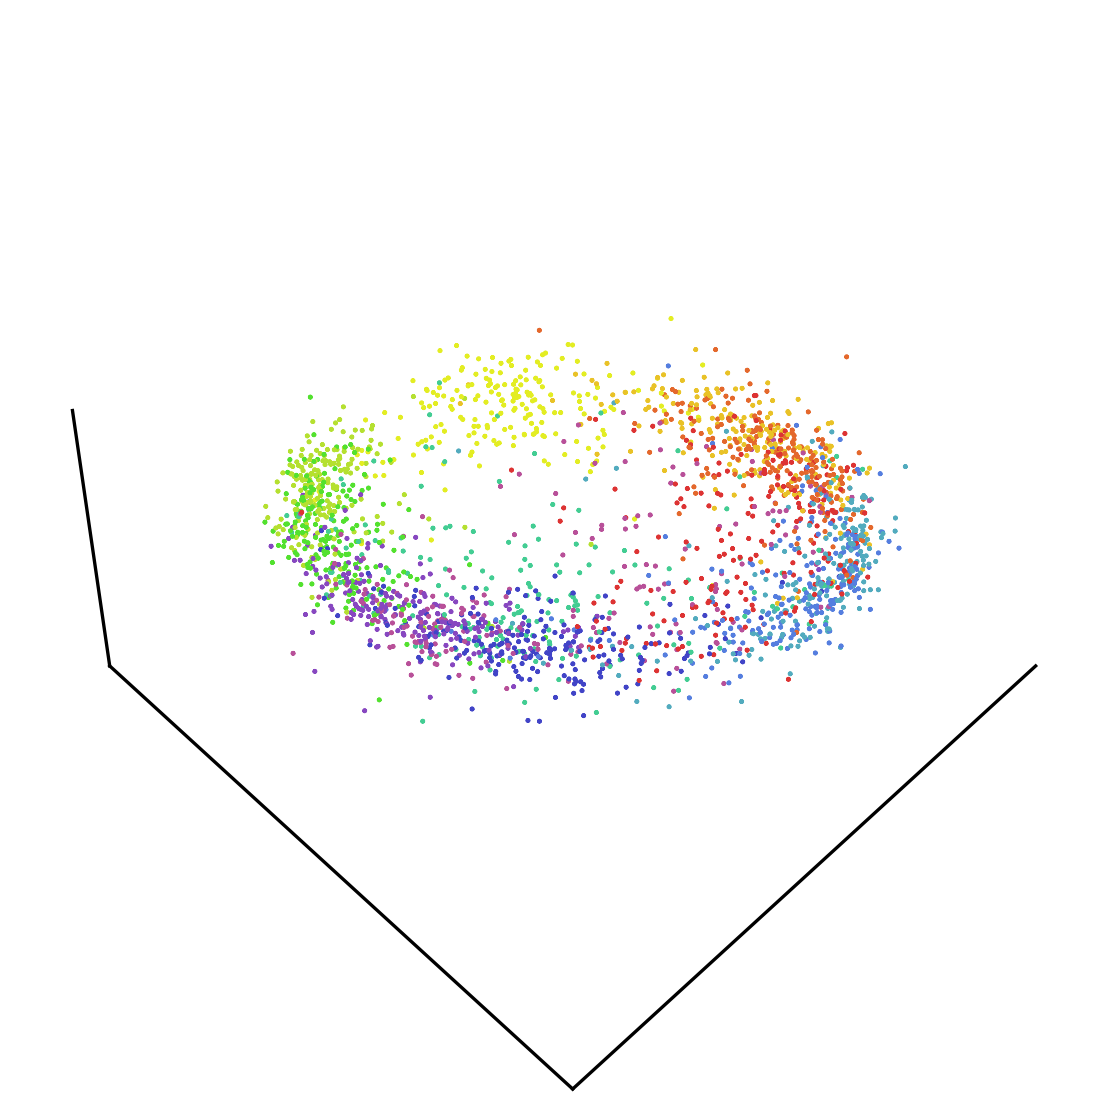

In [323]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(paired_colors)
seed = 0
fig = plt.figure(figsize=(10, 5), dpi=300)
#plt.suptitle('trained with direction label', fontsize=5)
#cmap = plt.cm.get_cmap('Paired', 12)
ax = plt.subplot(121, projection = '3d')
x = ax.scatter(embedding_train[seed][:, 0],
               embedding_train[seed][:, 1],
               embedding_train[seed][:, 2],
               c=label_train[0],
               cmap=custom_cmap,
               s=0.05,
               alpha=1.0,
               marker = '*')
#cbar = plt.colorbar(x, ax=ax, fraction=0.025, pad=0.02)  
#cbar.set_label('angles')  

set_pane_axis(ax)
ax.view_init(elev=60, azim=45)

<Axes: xlabel='Steps', ylabel='InfoNCE Loss'>

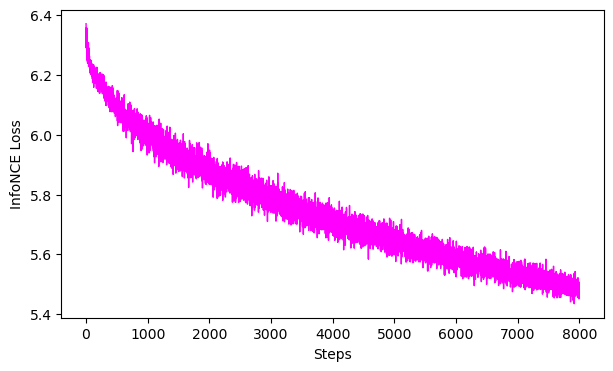

In [324]:
cebra.plot_loss(cebra_pos_model)

In [325]:
score = []
from sklearn.model_selection import cross_val_score
decoder = {}
cv_scores = {}
dir_pred = {}
acc_score = {}
for seed in range(10):
    decoder[seed] = KNeighborsClassifier(n_neighbors=10, metric="cosine")
    decoder[seed].fit(embedding_train[seed], label_train[0])
    cv_scores[seed] = cross_val_score(decoder[seed],embedding_train[seed], label_train[0], cv=10)
    dir_pred[seed] = decoder[seed].predict(embedding_test[seed])

In [326]:
res_15 = {}
for seed in range(10):
    a1 = len(label_test[seed][np.abs(dir_pred[seed] - label_test[seed])%12 <= 1])
    a2 = len(label_test[seed][np.abs(dir_pred[seed] - label_test[seed])%12 == 10])
    a3 = len(label_test[seed][np.abs(dir_pred[seed] - label_test[seed])%12 == 11])
    res_15[seed] = (a1+a3)/len(label_test[seed])
res_15

{0: 0.4675925925925926,
 1: 0.5138888888888888,
 2: 0.48842592592592593,
 3: 0.5462962962962963,
 4: 0.41898148148148145,
 5: 0.5300925925925926,
 6: 0.4444444444444444,
 7: 0.5370370370370371,
 8: 0.5092592592592593,
 9: 0.39351851851851855}

In [55]:
len(label_test[0])

432

In [330]:
res_0 = {}
for seed in range(10):
    a1 = len(label_test[seed][np.abs(dir_pred[seed] - label_test[seed])%12 == 0])
    #a3 = len(label_test[0][np.abs(dir_pred[seed] - label_test[0])%12 == 11])
    res_0[seed] = (a1)/len(label_test[seed])
res_0

{0: 0.23148148148148148,
 1: 0.2569444444444444,
 2: 0.22685185185185186,
 3: 0.2175925925925926,
 4: 0.1875,
 5: 0.25462962962962965,
 6: 0.18518518518518517,
 7: 0.2337962962962963,
 8: 0.25462962962962965,
 9: 0.18055555555555555}

In [116]:
selected_idx

{0: 35, 1: 35, 2: 35}

In [138]:
sorted_items = sorted(res_15.items(), key=lambda item: item[1])

# Display the sorted values and their corresponding keys
for key, value in sorted_items:
    print(f"Key: {key}, Value: {value}")


Key: 0, Value: 0.6377314814814815


In [331]:
pred_dir = {}
for seed in range(10):
    angs = np.arange(0,360,15)
    for dir in range(24):
        pred_dir[seed, dir] = dir_pred[seed][label_test[0] == dir]
pred_dir

{(0,
  0): array([16, 10,  0, 21,  5,  4,  5,  5, 21,  9,  4, 10, 20, 12,  4, 17, 16,
        14]),
 (0,
  1): array([ 8,  8, 13, 12,  7, 19,  6,  8, 20, 23, 12, 13, 14,  3, 14,  2, 13,
         2]),
 (0,
  2): array([12, 12,  3,  3,  2,  1,  2, 20, 15,  4,  3,  4, 12, 11, 19,  8,  3,
        14]),
 (0,
  3): array([ 5,  5,  4, 17, 15, 15,  3,  3, 12,  6,  2, 15,  4,  3,  2,  2,  3,
         3]),
 (0,
  4): array([14, 14, 22, 10, 22, 21,  5,  5,  3,  3,  4,  4, 16, 16,  3, 15, 15,
         4]),
 (0,
  5): array([17, 17,  9, 22, 17,  4,  4,  4,  4, 16,  5,  5,  4,  4,  4,  4, 17,
         6]),
 (0,
  6): array([ 6,  9,  3,  3, 10, 23,  3,  3,  5, 17, 22, 23, 15, 16, 23, 18, 20,
        19]),
 (0,
  7): array([ 0,  0,  5, 17,  6,  6, 12, 13, 19,  8,  2, 14,  2, 15,  3,  2,  2,
         2]),
 (0,
  8): array([ 5,  5,  0,  7,  8,  5, 16,  5, 20, 21,  2, 16, 10,  5, 16,  4,  4,
        14]),
 (0,
  9): array([ 5, 10,  5,  5,  9, 21,  9, 10, 22, 10, 21, 21, 23, 22,  4,  5, 12,
         4]),


In [141]:
pred_dir

{(0,
  0): array([12,  0,  0,  1,  0, 11, 11, 23,  0,  0,  0,  0,  0,  0, 11,  0,  0,
         0,  0,  0, 11,  0,  0,  0,  0, 11, 11, 23,  0,  0, 23, 18, 23, 23,
        23, 23]),
 (0,
  1): array([ 1,  1,  1,  1, 13,  2,  1,  1, 12, 12,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1, 22, 23, 23, 11, 10, 23, 23,  3,  0,  0,  0,  0,  3,  3,
         3,  3]),
 (0,
  2): array([16, 15,  3, 13,  2, 13,  1,  1, 13,  2,  1,  2,  1,  1,  1,  1, 12,
        12, 12, 12, 14, 14,  2,  2, 14,  2,  2,  2, 14,  2,  2, 13,  2, 13,
         1, 13]),
 (0,
  3): array([15, 15, 15, 15,  2, 14, 14,  3, 22, 23, 23, 11,  4,  4,  4,  4,  3,
         3,  3,  3,  3,  3,  3,  2, 11, 11, 11, 11,  1,  2,  2,  2, 16, 16,
        16, 16]),
 (0,
  4): array([23,  4, 23, 23, 17,  4,  4,  4, 16, 16,  4,  4, 16,  4,  4,  4, 16,
        16, 16, 16, 22,  4,  4,  4,  4, 10,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4]),
 (0,
  5): array([19,  6,  6, 17, 17, 17, 17, 17,  7, 17,  5,  4,  6,  6,  6,  6,  5,
         5,  5

In [334]:
mean_error_total = []
for seed in range(10):
    mean_error = {}
    std_error = {}
    total_error = defaultdict(list) 
    for dir in range(24):
        pred_diff = pred_dir[seed, dir] - dir
        for n in range(len(pred_dir[seed, dir])):
            if np.abs(pred_diff[n]) in np.arange(0,6):
                total_error[dir].append(np.abs(pred_diff[n])*15)
            elif np.abs(pred_diff[n]) in np.arange(6,12):
                total_error[dir].append((12-np.abs(pred_diff[n]))*15)
            elif np.abs(pred_diff[n]) in np.arange(12,18):
                total_error[dir].append((np.abs(pred_diff[n])-12)*15)
            elif np.abs(pred_diff[n]) in np.arange(18,24):
                total_error[dir].append((24-np.abs(pred_diff[n]))*15)
        mean_error[dir] = np.mean(total_error[dir])
        std_error[dir] = np.std(total_error[dir])
    mean_error_total.append(sum(mean_error.values())/len(mean_error.values()))


In [335]:
print([np.mean(mean_error_total),np.std(mean_error_total)])
mean_error_total

[43.91666666666667, 3.5038077281265054]


[34.166666666666664,
 43.36805555555555,
 45.833333333333336,
 45.381944444444436,
 44.09722222222223,
 45.27777777777778,
 47.118055555555564,
 46.90972222222222,
 43.229166666666664,
 43.78472222222223]

In [299]:
total_error = defaultdict(list) 
mean_error = {}
std_error = {}
seed = 1
for dir in range(24):
    pred_diff = pred_dir[seed, dir] - dir
    for n in range(len(pred_dir[seed, dir])):
        if np.abs(pred_diff[n]) in np.arange(0,6):
            total_error[dir].append(np.abs(pred_diff[n])*15)
        elif np.abs(pred_diff[n]) in np.arange(6,12):
            total_error[dir].append((np.abs(pred_diff[n]))*15)
        elif np.abs(pred_diff[n]) in np.arange(12,24):
            total_error[dir].append((24-np.abs(pred_diff[n]))*15)
    mean_error[dir] = np.mean(total_error[dir])
    std_error[dir] = np.std(total_error[dir])
print(mean_error)
#print(sum(mean_error.values())/len(mean_error.values()))

{0: 85.0, 1: 84.16666666666667, 2: 81.66666666666667, 3: 90.0, 4: 28.333333333333332, 5: 33.333333333333336, 6: 61.666666666666664, 7: 80.0, 8: 80.83333333333333, 9: 105.83333333333333, 10: 109.16666666666667, 11: 128.33333333333334, 12: 70.0, 13: 58.333333333333336, 14: 103.33333333333333, 15: 92.5, 16: 160.0, 17: 110.83333333333333, 18: 130.0, 19: 90.83333333333333, 20: 69.16666666666667, 21: 70.83333333333333, 22: 75.0, 23: 69.16666666666667}


In [ ]:
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/Mouse3/embedding_train_0.5x2_0.6', 'wb') as f:
    pickle.dump(embedding_train, f)
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/Mouse3/embedding_test_0.5x2_0.6', 'wb') as f:
    pickle.dump(embedding_test, f)


In [147]:
embedding_train = {}
embedding_test = {}
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/embedding_train_200', 'rb') as f:
    embedding_train = pickle.load(f)
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/embedding_test_200', 'rb') as f:
    embedding_test = pickle.load(f)


In [94]:
pred_dir = {}
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/pred_dir', 'rb') as f:
    pred_dir_pre = pickle.load(f)

In [97]:
with open(os.getcwd()+'/Recording_data/ROSE_Cornell/mean_error', 'rb') as f:
    mean_e = pickle.load(f)

In [15]:
embedding_train.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
decode_ang = pd.read_excel( os.getcwd() + '\Recording_data/ROSE_Cornell/Mouse3/decode.xlsx', engine='openpyxl')

In [ ]:
decode_ang

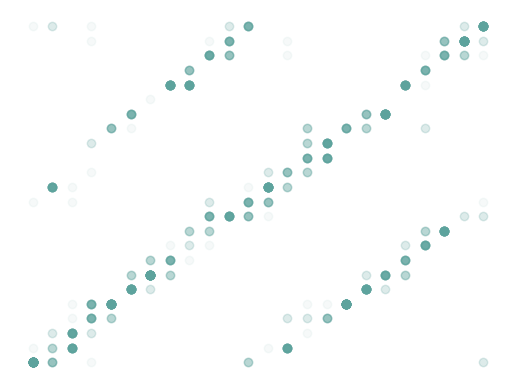

In [301]:
angs = np.arange(0,360,15)
decode_ang = []
alpha_list = defaultdict(list)
seed = 0
for dir in range(24):
    decode_ang.append(pred_dir[seed, dir])
    for n in range(len(decode_ang[0])):
        count = (decode_ang[dir] == decode_ang[dir][n]).sum() 
        alpha = count/len(decode_ang[dir])
        alpha_list[dir].append(alpha)
        plt.scatter(angs[dir], decode_ang[dir][n]*15, color = [93/255,163/255,157/255], alpha = alpha)
plt.axis('off')       
plt.show()


In [ ]:
res = pd.DataFrame()
for dir in range(24):
    res[dir] = decode_ang[dir]*15
    res[dir, alpha] = alpha_list[dir]
res.to_excel(os.getcwd() + '/Recording_data/ROSE_Cornell/Mouse3/predicts.xlsx', index=False, engine='openpyxl')

In [ ]:
mean_error_ang = []
for dir in range(12):
    mean_error_ang.append((mean_error[dir] + mean_error[dir+12])/2)

In [ ]:
mean_error = [9.79, 10.4, 3.3, 11.25, 5, 2.7, 4.59,  ]

In [ ]:
angs = np.arange(0,180,15)
plt.figure(figsize = (15,6))
plt.bar(angs, mean_error_ang, width = 10, color = 'cadetblue')
plt.tick_params(axis='both', which='major', labelsize =20)
plt.ylim(0,25)

In [ ]:
step = 0.55
fs = 20000
ang_curve = defaultdict(list)
fr = defaultdict(list)
mean_fr_ang = defaultdict(list)
spike_count = defaultdict(list)
for (ch,unit) in spike_time_all.keys():
    r= np.array(spike_time_all[ch,unit])
    for A in np.arange(0, 360, 15):
        for idx, time in enumerate(onset_time[np.where(angle == A)]):
            on_time = time + 0.05
            rate_after = ((int(on_time*fs) <= r) & (r < int(on_time*fs + step*fs))).sum()
            spike_count[ch,unit, A].append(rate_after)
        ang_curve[ch,unit].append(spike_count[ch, unit, A])


In [ ]:
fig, axs = plt.subplots(8, 16, sharex = 'col', sharey = 'row')
ang_in_order = np.arange(0, 360, 15)
for (ch,unit) in spike_time_all.keys():
  y = shank_no[ch]
  x = elec_no[ch]
  axs[8-x][y-1].plot(ang_in_order, np.mean(ang_curve[ch,unit], axis = 1), 'seagreen',linewidth=5, label = "s%d"%(y) + "e%d"%(x))
  axs[8-x][y-1].legend()
  axs[8-x][y-1].tick_params(axis='x', which='major', labelsize = 20)
  #axs[8-x][y-1].set_ylim(5, 15)
  fig.set_figheight(40)
  fig.set_figwidth(60)

In [ ]:
elec_no[110:120]

In [ ]:
OSI = {}
rate_by_angle = {}
max_rate = {}
prefer_ang = {}
for (ch,unit) in spike_time_all.keys():
    rate_by_angle[ch,unit] = np.mean(ang_curve[ch,unit], axis = 1)
    max_rate[ch,unit] = max(rate_by_angle[ch,unit])
    max_index = np.argmax(rate_by_angle[ch,unit])
    if max_index < 6:
        orth_index = max_index + 6 
    if max_index >= 6 and max_index <12:
        orth_index = max_index - 6 
    if max_index >= 12 and max_index < 18:
        orth_index = max_index + 6
    if max_index >= 18:
        orth_index = max_index - 6
    OSI[shank_no[ch], elec_no[ch]-1, unit] = [max_index, (rate_by_angle[ch, unit][max_index] - rate_by_angle[ch, unit][orth_index])/rate_by_angle[ch, unit][max_index]]

In [ ]:
OSI

In [ ]:
lh_ratio = {}
rate_by_angle = {}
max_rate = {}
min_rate = {}
for i in range(16):
    shank_num = shank_no[i*8]
    for unit_id in sorting[shank_no[i*8]].get_unit_ids():
        rate_by_angle[shank_num, unit_id] = np.mean(ang_curve[shank_num,unit_id], axis = 1)
        max_rate[shank_num, unit_id] = max(rate_by_angle[shank_num, unit_id])
        min_rate[shank_num, unit_id] = min(rate_by_angle[shank_num, unit_id])
        lh_ratio[shank_num, unit_id]  = (max_rate[shank_num, unit_id] - min_rate[shank_num, unit_id])/max_rate[shank_num, unit_id]
        

In [ ]:
plt.plot(lh_ratio.values())

In [ ]:
fig, axs = plt.subplots(10, 16, sharex = 'col', sharey = 'row')
spike_time_all = {}
for i in range(16):
    shank_num = shank_no[i*8]
    for unit_id in sorting[shank_no[i*8]].get_unit_ids():
      x = unit_id - 1
      y = shank_no[i*8] - 1
      if lh_ratio[shank_num, unit_id] > 0.4:
          spike_time_all[shank_num, unit_id] = sorting[shank_num].get_unit_spike_train(unit_id)
          axs[x][y].plot(ang_in_order, np.mean(ang_curve[shank_num,unit_id], axis = 1), 'seagreen',linewidth=5, label = "s%d"%(shank_no[i*8]) + "u%d"%(unit_id))
      axs[x][y].tick_params(axis='x', which='major', labelsize = 30)
      #axs[x][y].set_ylim(-180, 150)
      fig.set_figheight(40)
      fig.set_figwidth(60)

In [ ]:
len(ang_curve[shank_num,unit_id])
find_index_of_max(ang_curve[shank_num,unit_id])

In [ ]:
fig, axs = plt.subplots(8, 16, sharex = 'col', sharey = 'row')
ang_in_order = np.arange(0, 360, 15)
for i in range(16):
    shank_num = shank_no[i*8]
    for unit_id in sorting[shank_no[i*8]].get_unit_ids():
      channel = ch_to_unit[shank_no[i*8]][unit_id]
      x = 8 - pinmap[channel][1]
      y = shank_no[i*8] - 1
      axs[x][y].plot(ang_in_order, np.mean(ang_curve[shank_num,unit_id], axis = 1), 'seagreen',linewidth=5)#, label = "s%d"%(shank_no[i*8]) + "u%d"%(unit_id))
      axs[x][y].set_title("channel%d"%(channel))
      #axs[x][y].legend()
      axs[x][y].tick_params(axis='x', which='major', labelsize = 30)
      #axs[x][y].set_ylim(-180, 150)
      fig.set_figheight(40)
      fig.set_figwidth(60)

In [ ]:
spike_time_trial = {}

In [ ]:
for cluster_id in non_noise:
    unit = 0 
    channel = int(min(spike_uncurated[0][spike_uncurated[2]==cluster_id]))-1
    while (channel, unit) in spike_time_trial.keys():
        unit = unit+1
    spike_time_trial[channel,unit] = cluster_time_stamp[cluster_id]
    

In [ ]:
len(spike_time_trial.keys())

In [ ]:
#channel based spike time
spike_time_ch = {}
for key, values in spike_time_all_clust[trial].items():
    new_key = key[0]
    if new_key not in spike_time_ch:
        spike_time_ch[new_key] = values
    else:
        # Summing the lists element-wise
        spike_time_ch[new_key] = sorted(spike_time_ch[new_key] + values)

In [ ]:
trial = 41
start = 0
end =int(len(filtered[0])/fs)
L = 1.5
step = 0.05
points = int(L/step)
stim_bin = []
fr = defaultdict(list)
mean_fr = {}

for ch in spike_time_ch.keys():
    r = np.array(spike_time_ch[ch])
    for time in onset_time[trial][0:20]: 
        scount = []
        on_time = int((time-0.5)*fs)
        for n in range(points):
            spike_count = (((int(on_time + step*fs*n) <= r) & (r < int(on_time + step*fs*(n+1)))).sum())/step
            scount.append(spike_count)
        fr[ch].append(scount)
    mean_fr[ch] = np.mean(fr[ch], axis = 0) 

In [ ]:
spike_time_cor = {}
temp = {}
fr_3D = []

for ch in range(128):
    if ch in spike_time_ch.keys():
        temp[pinmap[ch]] = np.array(mean_fr[ch])
    else:
        temp[pinmap[ch]] = np.zeros(len(mean_fr[1]))
for s in range(1,33,1):
    for e in range(1,5,1):
        fr_3D.append(temp[s,e])

In [ ]:
t1 = onset_time[41][0]-0.5
t2 = onset_time[41][0]+1
c1 = int(t1/step)
c2 = int(t2/step)-1
columns = [row[c1:c2] for row in fr_3D]

In [ ]:
df_columns = pd.DataFrame(fr_3D)
df_columns

In [ ]:
df_columns.to_excel("firingrates.xlsx", index=False, engine='openpyxl')

In [ ]:
with open(os.getcwd()+'/Recording_data/0914/Sorted/neural', 'wb') as f:
    pickle.dump(neural_data, f)
with open(os.getcwd()+'/Recording_data/0914/Sorted/directions', 'wb') as f:
    pickle.dump(directions, f)   


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_neural = scaler.fit_transform(neural_data)


In [ ]:
rate_by_angle = defaultdict(list)
rate_by_stim = defaultdict(list)
for chs,unit in rate_diff.keys(): 
    for ang in range(0,360,30):
        if angle_repeat[chs, unit, ang]:
            rate_by_angle[chs,unit].append(np.sum(rate_diff_angle[chs,unit,ang])/len(angle_repeat[chs, unit, ang]))
        else:
            rate_by_angle[chs,unit].append(0)
    for stim in range(int(len(rate_diff[chs,unit])/12)):
        for ang in range(0,360,30):
            rate_by_stim[chs,unit,stim].append(rate_diff_angle[chs,unit,ang][stim])

In [ ]:
max_angle = {}
max_rate = {}
orth_angle = {}
orth_rate = {}
ORI = {}
rate_by_angle_gau = {}
sigma =0.8
for chs,unit in rate_by_angle.keys():
    if not rate_by_angle[chs,unit]:
        continue
    rate_by_angle_gau[chs,unit] = gaussian_filter(rate_by_angle[chs,unit], sigma=sigma)
    sorted_indices = np.argsort(rate_by_angle_gau[chs,unit])
    max_idx = sorted_indices[-1]
    max_rate[chs,unit] = rate_by_angle_gau[chs,unit][max_idx]
    if max_rate:
        max_angle[chs,unit] = max_idx*30
    else:
        max_angle[chs,unit] = 0
    if max_angle[chs,unit] < 90:
        orth_angle[chs,unit] = max_angle[chs,unit]+90
    else:
        orth_angle[chs,unit] = max_angle[chs,unit]-90
    orth_rate[chs,unit] = rate_by_angle_gau[chs,unit][int(orth_angle[chs,unit]/30)] 
    if max_rate[chs,unit]:
        ORI[chs,unit] = (max_rate[chs,unit] - orth_rate[chs,unit]) / max_rate[chs,unit]
    else:
        ORI[chs,unit] = 0
        

In [ ]:
ORI_fil = [x for x in ORI.values() if x != 0 and x<1]
plt.hist(ORI.values())
#plt.ylim(0,20)

In [ ]:
fig, axs = plt.subplots(4, 32, sharex = 'col', sharey = 'row')
for chs, unit in ORI.keys():
  y = shank_no[chs]
  x = elec_no[chs]
  axs[x-1][y-1].plot(angles,rate_by_angle[chs,unit],linewidth = 20,color = 'steelblue')
  axs[x-1][y-1].set_title('s%d'%(y)+'-e%d'%(x),size = 30)
  #axs[x-1][y-1].set_ylim([-100, 100])
  axs[x-1][y-1].tick_params(axis='both', which='major', labelsize = 30)
  fig.set_figheight(20)
  fig.set_figwidth(200)
  axs[x-1][y-1].get_yaxis().set_visible(True)
  axs[x-1][y-1].get_xaxis().set_visible(False)

In [ ]:
angles = np.arange(0,360,30)

stim_no = int(len(rate_diff[4,0])/12)
fig, axs = plt.subplots(stim_no, 1, sharex = 'col', sharey = 'row')
for stim in range(stim_no):
    axs[stim].plot(angles, np.array(rate_by_stim[95,0,stim]), linewidth = 5, color = 'steelblue')
    fig.set_figheight(20)
    fig.set_figwidth(10)
    axs[stim].tick_params(axis='both', which='major', labelsize=25)
    #plt.legend('%d'%(stim))
plt.show()

#plt.ylim(0,12)

In [ ]:
rate_order = []
stim_no = int(len(rate_diff[4,0])/12)
order = np.arange(0,12,1)
for n in range(stim_no):
    rate_order.append(rate_diff[4,0][n*12:(n+1)*12])
mean_rate_order = np.mean(rate_order,axis= 0)
plt.plot(order,np.mean(rate_order,axis= 0))   

In [ ]:
angles = order = np.arange(0,360,30)
fig, ax = plt.subplots()
ax.plot(angles, rate_by_angle_gau[51,0]*10, linewidth = 5, color = 'steelblue')

In [ ]:
line = ax.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()
data_dict = {"X": x_data.tolist(), "Y": y_data.tolist()}
with open(os.getcwd()+'/Recording_data/0914/exported_data/ch7.json', 'w') as file:
    json.dump(data_dict, file)

In [ ]:
ColorPalette = pd.read_excel( os.getcwd() + '/ColorPalettes.xlsx', engine='openpyxl')
colors = ColorPalette[['R','G','B']].values/255

In [ ]:
#channel based
rate_by_angle_ch = {}
for key, values in rate_by_angle.items():
    new_key = key[0]
    if new_key not in rate_by_angle_ch:
        rate_by_angle_ch[new_key] = values
    else:
        # Summing the lists element-wise
        rate_by_angle_ch[new_key] = np.array(rate_by_angle_ch[new_key]) + np.array(values)

In [ ]:
np.median(fDD['ORI'])

In [ ]:
sh = []
el = []
for key in ORI.keys():
    sh.append(shank_no[key[0]])
    el.append(elec_no[key[0]])

DD = pd.DataFrame()
DD['shank_no'] = sh
DD['elec_no'] = el
DD['channel,unit'] = ORI.keys()
DD['max angle'] = max_angle.values()
DD['max rate'] = max_rate.values()
DD['orth rate'] = orth_rate.values()
DD['ORI'] = ORI.values()
DD = DD.round(2)
fDD = DD[DD['ORI'] > 0.499]
res = fDD[fDD['ORI'] < 1.1]

pd.set_option('display.max_rows', None)

res




In [ ]:
counts = Counter(res['max angle'])
summary = {}

for a in angles:
    if (a+180) < 360:
        if a not in counts.keys():
            counts[a] = 0
        summary[(a,a+180)] = (counts[a]+counts[a+180])/sum(counts.values())
rounded_sum = pd.Series(summary).round(2).to_dict()

rounded_sum


In [ ]:
O = {}
ori = defaultdict(list)
for trial in [trial_no]:
    for ch in range(128):
        if (trial,ch) in ORI_ch:
            O[pinmap[ch]] = ORI_ch[trial,ch]
        else:
            O[pinmap[ch]] = 0
    for s in range(32,0,-1):
        for e in range(1,5,1):
            ori[trial].append(O[s,e])
#ori_df.to_excel(os.getcwd()+'/Recording_data/0817ROSE/Sorted Units/ori.xlsx', index=False, engine='openpyxl')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm



fig = plt.figure(figsize = (25,25))

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

 # Hide axes and grid lines
ax.axis('off')
ax.grid(False)
ax.set_zlim([0,12000])
c_data = np.array(ori[trial_no])

# Choose a colormap
colormap = sns.color_palette("flare", as_cmap=True)

# Min and max color values for the colormap
cmin = 0
cmax = 1

    # Function to plot a sphere
def plot_sphere(ax, x, y, z, radius, color, alpha, steps=30):
    phi = np.linspace(0, np.pi, steps)
    theta = np.linspace(0, 2 * np.pi, steps)
    phi, theta = np.meshgrid(phi, theta)
    
        # Convert to Cartesian coordinates
    x_sphere = x + radius * np.sin(phi) * np.cos(theta)
    y_sphere = y + radius * np.sin(phi) * np.sin(theta)
    z_sphere = z + radius * np.cos(phi)
    
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color=color, alpha=alpha, shade=True)

    # Plot spheres at data points with colors from c_data
for x, y, z, c in zip(cor_x*12, cor_y*12, cor_z*21, c_data):
    color_val = (c - cmin) / (cmax - cmin)
    color = colormap(color_val)[:3]  # Ignore the alpha value from the colormap
    if c <= 0:
        plot_sphere(ax, x, y, z, color='slategray',radius = 200, alpha = 0.1)
    else:
        plot_sphere(ax, x, y, z, color=color,radius = 200+c*20, alpha = 1)


    ax.view_init(elev=78, azim=42)    
    # Show plot
plt.show()

In [ ]:
mean_values = {}
for ch in range(128):
    D = defaultdict(list)
    for trial in [2,3,4,5]:
        for idx,ang in enumerate(angle.iloc[trial-1]):   
            if (trial,ch) in  rate_diff_ch:
               D[ang].append(rate_diff_ch[trial,ch][idx])
    mean_values[ch] = {key: sum(values) / len(values) for key, values in D.items()}

fav_ang = []
fav_rate = []
orth_ang = []
orth_rate = []
ORI_avg = {}
for ch in mean_values.keys():
    if mean_values[ch]:
        m_ang = max(mean_values[ch], key=mean_values[ch].get)
        fav_ang.append(m_ang)
        fav_rate.append(mean_values[ch][m_ang])
        if m_ang < 90:
            o_ang = max(mean_values[ch], key=mean_values[ch].get)+90
        else: 
            o_ang = max(mean_values[ch], key=mean_values[ch].get)-90
        orth_ang.append(o_ang)
        orth_rate.append(mean_values[ch][o_ang])
    else:
        fav_ang.append(-200)
        orth_ang.append(-200)
        fav_rate.append(0)
        orth_rate.append(0)

    if fav_rate[-1] >= 5/length:
        ORI_avg[ch] = (fav_rate[-1] - orth_rate[-1]) / fav_rate[-1]
    else:
        ORI_avg[ch] = 0
sh = []
el = []
for ch in mean_values.keys():
    sh.append(shank_no[ch])
    el.append(elec_no[ch])

DD = pd.DataFrame()
DD['shank_no'] = sh
DD['elec_no'] = el
DD['max angle'] = fav_ang
DD['max rate'] = fav_rate
DD['orth angle'] = orth_ang
DD['orth rate'] = orth_rate

DD['ORI'] = ORI_avg.values()
DD = DD.round(2)
fDD = DD[DD['ORI'] > 0]
fDD        

In [ ]:
A = {}
max_A = []
for ch in range(128):
    A[pinmap[ch]] = max_angle[ch]
for s in range(32,0,-1):
    for e in range(1,5,1):
        max_A.append(A[s,e])
array = pd.DataFrame(max_A) 

array.to_excel(os.getcwd()+'/Recording_data/0824ROSE/Sorted Units/array.xlsx', index=False, engine='openpyxl')

In [ ]:
#channel based
rate_diff_ch = defaultdict(list)
for key, values in rate_diff.items():
    a, b, _ = key
    new_key = (a, b)
    if new_key not in rate_diff_ch:
        rate_diff_ch[new_key] = values
    else:
        # Summing the lists element-wise
        rate_diff_ch[new_key] = [x + y for x, y in zip(rate_diff_ch[new_key], values)]

In [ ]:
units = (0,0)
fig, axs = plt.subplots(1, 12, sharex = 'col', sharey = 'row')
for idx,trial in enumerate([2,3,4,5,6,8,10,11,12,13,14,15]):
    if units in data_wave[trial]:
        axs[idx].plot(data_wave[trial][units])
        axs[idx].set_title('trial%d'%(trial))
fig.set_figheight(5)
fig.set_figwidth(50)



In [ ]:
units = (5,0)
start = 0
end = 110
L = end - start
step = 0.5
points = int(L/step)
#stim_bin = signal.resample(stim,points)

fig, axs = plt.subplots(12, 1, sharex = 'col', sharey = 'row')
for idx,trial in enumerate([2,3,4,5,6,8,10,11,12,13,14,15]):
    fr = []
    if units in data_stamp[trial]:
        r = np.array(data_stamp[trial][units])
    else:
        continue
    for n in range(points):
        rate = (((int(step*fs*n) <= r) & (r < int(step*fs*(n+1)))).sum())/step
        fr.append(rate)
     
    bin = np.arange(0, end-start , step)
    axs[idx].bar(bin,fr,color = 'slategray',width =2)
    for time in onset_time[trial]:
        axs[idx].axvline(x=time, color='r', linestyle='--')
    yl =20
    axs[idx].set_ylim(0,yl)
    axs[idx].set_xlim(int(0),int(115))
    axs[idx].set_title('trial%d'%(trial),size=20)
    axs[idx].tick_params(axis='both', which='major', labelsize=20)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
fig.set_figheight(30)
fig.set_figwidth(10)


In [ ]:
max_evoked = defaultdict(list)
max_rate = defaultdict(list)
unit = 0
for trial in [12]:
    D = defaultdict(list)
    for ch in range(128):
        if max_angle[trial,ch,unit]:
            max_evoked[trial].append((max_angle[trial,ch,unit]))
            max_rate[trial].append(max_rate_diff[trial,ch,unit])
        else:
            max_evoked[trial].append([-200])
            max_rate[trial].append([-200])
        for idx,ang in enumerate(angle.iloc[trial-1]):   
            if rate_diff[trial,ch,unit] :
               D[ang].append(rate_diff[trial,ch,unit][idx])

    plt.figure(figsize=(15,5))
    keys = list(mean_values.keys())
    values = list(mean_values.values())
    plt.bar(keys, values,width = 20,color = 'lightseagreen')
    #plt.show()
    plt.ylim(0,10)

In [ ]:
evo0 = pd.DataFrame(max_evoked[2])
#evo1 = pd.DataFrame(max_evoked[3])
#evo2 = pd.DataFrame(max_evoked[4])
#evo3 = pd.DataFrame(max_evoked[5])
#evo4 = pd.DataFrame(max_evoked[10])
#evo5 = pd.DataFrame(max_evoked[11])
#evo6 = pd.DataFrame(max_evoked[12])

result = pd.concat([evo0, evo1,evo2,evo3,evo4,evo5,evo6], axis=1)
result.to_excel(os.getcwd()+'/Recording_data/0817ROSE/Sorted Units/angle.xlsx', index=False, engine='openpyxl')

In [ ]:
A = {}
fav = defaultdict(list)
for trial in [12]:
    for ch in range(128):
        A[pinmap[ch]] = max_evoked[trial][ch][0]
    for s in range(32,0,-1):
        for e in range(1,5,1):
            fav[trial].append(A[s,e])
fav_df = pd.DataFrame(fav) 
fav_df
fav_df.to_excel(os.getcwd()+'/Recording_data/0817ROSE/Sorted Units/fav_angle.xlsx', index=False, engine='openpyxl')

In [ ]:
v = defaultdict(list)
angle_trial = angle.iloc[0][12:24]
unit = 0
for ch in range(128):
    for idx,ang in enumerate(angle_trial):
        if ch in rate_diff_ch.keys():
           v[ang].append(rate_diff_ch[ch][idx])
        else:
           v[ang].append(0)

res = {}
rose = defaultdict(list)
for ang in angle_trial: 
    for ch in range(128):
        res[pinmap[ch]] = v[ang][ch]
    for s in range(32,0,-1):
        for e in range(1,5,1):
           rose[ang].append(res[s,e])
rose_df = pd.DataFrame(rose)       
rose_df

In [ ]:
res = {}
rose = defaultdict(list)
for idx, ang in enumerate(angles):
    for ch in range(128):
        if ch in rate_by_angle_ch.keys():
            res[pinmap[ch]] = rate_by_angle_ch[ch][idx]
        else:
            res[pinmap[ch]] = 0
    for s in range(32,0,-1):
        for e in range(1,5,1):
           rose[ang].append(res[s,e])
rose_df = pd.DataFrame(rose)       
rose_df


In [ ]:
max_angle_ch = {}
for chs, unit in max_angle.keys():
    if chs not in max_angle_ch.keys():
        max_angle_ch[chs] = [max_angle[chs,unit],ORI[chs,unit], max_rate[chs,unit]]
    else:
        if ORI[chs,unit] > max_angle_ch[chs][1]:
            max_angle_ch[ch] = [max_angle[chs,unit],ORI[chs,unit],max_rate[chs,unit]]

In [ ]:
temp = {}
max_angle_remap = []

for ch in range(128):
    if ch in max_angle_ch.keys() and max_angle_ch[ch][1] >= 0.5 and max_angle_ch[ch][2]> 0:
        temp[pinmap[ch]] = max_angle_ch[ch][0]
    else:
        temp[pinmap[ch]] = -99
for s in range(1,33,1):
    for e in range(1,5,1):
        max_angle_remap.append(temp[s,e])

In [ ]:
max_angle_remap

In [ ]:
angle_excel = pd.DataFrame()
angle_excel['x'] = cor_x
angle_excel['y'] = cor_y
angle_excel['z'] = cor_z
angle_excel['angle'] = max_angle_remap

In [ ]:
angle_excel.to_excel("15trials.xlsx", index=False, engine='openpyxl')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
directions = []
angle_color = []
angle_alpha = []
# Sample data
points = np.stack((cor_x*42, cor_y*42, cor_z*81), axis=1)

# Define angles in radians from 0 to 330 degrees with 30-degree steps


# Compute directions for lines based on angles
for ang in max_angle_remap:
    angle_rd = np.deg2rad(ang)
    directions.append((np.sin(angle_rd),0,np.cos(angle_rd))) #XZ
    #directions.append((np.cos(angle_rd),np.sin(angle_rd),0)) #XY
    if ang == -99:
        angle_color.append([1,1,1])
        angle_alpha.append(0)
    else:
        angle_color.append(colors[int(ang/30)])
        angle_alpha.append(1)
# Create 3D figure

fig = plt.figure(figsize = (45,30))
ax = fig.add_subplot(111, projection='3d')

line_length = 1500
# For each point, plot in a circular pattern with the given directions
for idx, point in enumerate(points):
        end_point = point + np.array(directions[idx]) * line_length
        #ax.scatter(*point, s = 100, color = 'gray', alpha = angle_alpha[idx] )
        ax.plot([point[0], end_point[0]], [point[1], end_point[1]], [point[2], end_point[2]], color=angle_color[idx], linewidth = 10, alpha = angle_alpha[idx])
        #plt.text(*points, *max_angle_remap)

# Set plot limits and labels, then display
#ax.set_xlim([0, 10])
#ax.set_ylim([0, 10])
#ax.set_zlim([0, 10])
ax.axis('off')
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=80, azim=-40)
#ax.view_init(elev=90, azim=0)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm



#for ang in range(0,360,30):
# Create a figure
fig = plt.figure(figsize = (25,25))

# Add 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Hide axes and grid lines
ax.axis('off')
ax.grid(False)
#ax.set_zlim([0,42000])
#c_data = np.array(max_angle_remap)

# Choose a colormap
#colormap = sns.color_palette("flare", as_cmap=True)

# Min and max color values for the colormap
#cmin = 0
# cmax = 5

# Function to plot a sphere
def plot_sphere(ax, x, y, z, radius, color, alpha, steps=30):
    phi = np.linspace(0, np.pi, steps)
    theta = np.linspace(0, 2 * np.pi, steps)
    phi, theta = np.meshgrid(phi, theta)
    
    # Convert to Cartesian coordinates
    x_sphere = x + radius * np.sin(phi) * np.cos(theta)
    y_sphere = y + radius * np.sin(phi) * np.sin(theta)
    z_sphere = z + radius * np.cos(phi)
    
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color=color, alpha=alpha, shade=True)

    # Plot spheres at data points with colors from c_data
for idx, point in enumerate(points):
    #color_val = (c - cmin) / (cmax - cmin)
    #color = colormap(color_val)[:3]  # Ignore the alpha value from the colormap
    plot_sphere(ax, point[0]*21, point[1]*21, point[2]*42, color=angle_color[idx], alpha = angle_alpha[idx], radius = 20000)
    ax.view_init(elev=78, azim=42)    
    # Show plot
plt.show()


In [ ]:
order = 2
low = 1
high = 300
fs = 20000
lfp = []
b,a = signal.butter(order, [low, high], 'bp', fs=fs)
for row in raw_data:
  lfp.append(signal.lfilter(b, a, row))
med = np.median(lfp,axis=0)
lfp = lfp - med

In [ ]:
fs = 20000
session = defaultdict(list)
session_mean = {}
stimuli = onset_time[0:50]
for ch in range(128):
  for n, time in enumerate(stimuli):
      begin = int((time - 0.5)*fs)
      end = begin + int(1.5*fs)
      session[ch].append(lfp[ch][begin:end])
  session_mean[ch] = np.mean(session[ch],axis = 0)


In [ ]:
fig, axs = plt.subplots(8, 16, sharex = 'col', sharey = 'row')
time_axis = np.linspace(0,1.5,int(1.5*fs))
on = 0.5
off = 1
for ch in range(128):
  y = shank_no[ch]
  x = 7 - elec_no[ch]
  axs[x-1][y-1].plot(time_axis, session_mean[ch], c='black', linewidth = 3)
  #axs[x-1][y-1].set_title('s%d'%(y)+'-e%d'%(x)+":ch%d"%(ch),size = 15)
  axs[x-1][y-1].fill_between(time_axis, -100, 100, where=(time_axis>=on) & (time_axis<=off), color='slategray', alpha=0.15)
  axs[x-1][y-1].axis('off')
  axs[x-1][y-1].set_ylim([-80, 80])
  axs[x-1][y-1].tick_params(axis='x', which='major', labelsize = 30)
  fig.set_figheight(50)
  fig.set_figwidth(100)
  axs[x-1][y-1].get_yaxis().set_visible(True)
  #axs[x].get_xaxis().set_visible(False)

In [ ]:
v_stim = []
v_pre = []
for ch in range(64):
    v_pre.append(max(session_mean[ch][0:15000]) - min(session_mean[ch][0:15000]))
    v_stim.append(max(session_mean[ch][15000:45000]) - min(session_mean[ch][15000:45000]))      

In [ ]:
evoked = []
for ch in range(64):
    if v_stim[ch] > v_pre[ch]:
        evoked.append(v_stim)
print([len(evoked),np.mean(evoked),np.std(evoked)])        

In [ ]:
pxx,  freq, t, cax = plt.specgram(filtered[1], Fs=20000,cmap="plasma", NFFT=4000, noverlap=3600, mode = 'psd')
#stim_wave = signal.resample(stim_pulse[int(18*fs):int(26*fs)],len(t))
#plt.plot(t,stim_wave*30,color='white',linewidth = 40)
plt.ylim([1, 150])
plt.xlim([122,127])
plt.tick_params(axis='both', which='major', labelbottom=True, labelleft=True, labelsize=50)
plt.axis('off')
cax.set_clim(vmin=-5, vmax=10) 
fig = plt.gcf()
fig.set_size_inches(100, 20) 

In [ ]:
len(raw_data_stim_pre[5][0])/20000

In [ ]:
plt.figure(figsize=(150, 45))
f, t, Sxx = signal.spectrogram(lfp[0], fs=20000, nperseg=6000, noverlap=5500, mode='psd')
cax = plt.imshow(Sxx, aspect='auto', origin='lower', extent=[min(t), max(t), min(f), max(f)],interpolation='nearest', cmap="plasma", vmin=0, vmax=30)
plt.xlim([on_time/fs,off_time/fs])
plt.ylim([1, 200])
#plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
colors = [(random.randint(0, 255)/255, random.randint(0, 255)/255, random.randint(0, 255)/255) for _ in range(128)]
spike_time_all = spike_time_all_clust[41]
plt.figure(figsize=(200,100))
unit_no = len(spike_time_all)
pos = 0 
for ch, clust in spike_time_all.keys():
    for timestamp in spike_time_all[ch,clust]:
        
        plt.axvline(timestamp, ymin=(len(spike_time_all)-pos)*2/unit_no/2, ymax=((len(spike_time_all)-pos)*2+1)/unit_no/2, color = colors[pos], linewidth = 20)
        
    pos = pos + 1
   
plt.axis('off')
plt.xlim(int(18*fs),int(26*fs))
plt.ylim(-5,5)
plt.show()

In [ ]:
rate_diff = defaultdict(list)
rate_onset = defaultdict(list)
rate_diff_angle = defaultdict(list)
angle_repeat = defaultdict(list)
length = 0.5
stride = 0.5
evoked = defaultdict(list)
X = []
Y = []
for idx, t in enumerate(onset_time):
    temp = defaultdict(list)
    temp_transpose = []
    Y.append(angle_all[idx]) 
    for chs,unit in spike_time_all.keys(): 
        train = spike_time_all[chs,unit] 
        t_after = t - 0.05
        #t_before = t - 0.05
        for n in range(int(length/stride)):
            rate_after = ((int(t_after*fs+n*stride*fs) <= np.array(train)) & (np.array(train) < int(t_after*fs+(n+1)*stride*fs))).sum()/stride
            if idx%12 <= 100:
                temp[chs,unit].append(rate_after)               
            else:
                temp[chs,unit].append(0)
        temp_transpose.append(temp[chs,unit])
    X.append(np.transpose(temp_transpose))
        

In [ ]:
X = np.array(X)
Y = np.array(Y)
unique_labels = np.sort(np.unique(Y))
label_to_index = {label:idx for idx, label in  enumerate(unique_labels)}
Y_indexed = [label_to_index[label] for label in Y] 
Y_one_hot = to_categorical(Y_indexed)

In [ ]:
num_samples, num_time_steps, num_features = X.shape
X_reshaped = X.reshape(-1, num_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
scaler = StandardScaler()
X_train= X_train.reshape(-1, num_features)
X_train = scaler.fit_transform(X_train)
X_test= X_test.reshape(-1, num_features)
X_test = scaler.transform(X_test)
X_val= X_val.reshape(-1, num_features)
X_val = scaler.transform(X_val)

In [ ]:
X_train= X_train.reshape(-1,num_time_steps,num_features)
X_test= X_test.reshape(-1,num_time_steps,num_features)
X_val= X_val.reshape(-1,num_time_steps,num_features)


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences = True))
model.add(Dropout(0.1))
#model.add(LSTM(64,return_sequences = True))  # Additional LSTM layer
#model.add(Dropout(0.1))
#model.add(LSTM(64)) 
#model.add(Dropout(0.1))
#model.add(Dense(y_train.shape[1], activation='softmax'))  # Modify based on your task

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10,validation_data=(X_val, y_val))

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
n_super_neurons = 12
sigma = 0.1
theta_k = np.linspace(0, 2 * np.pi, n_super_neurons, endpoint=False)


In [ ]:
theta_k

In [ ]:
def simulate_super_neuron_responses(stimulus_angles, preferred_angles, sigma):
    super_neuron_responses = np.exp((np.cos(stimulus_angles - preferred_angles) - 1) / sigma)
    return super_neuron_responses

In [ ]:
super_neuron_labels = []
for angle in angles:
    angle_rad = np.radians(angle)
    super_neuron_response = []
    for k in range(n_super_neurons):
        super_neuron_response.append(simulate_super_neuron_responses(angle, theta_k[k], 0.1))
    super_neuron_labels.append(super_neuron_response)
    

In [ ]:
angles

In [ ]:
plt.plot(super_neuron_labels[3])

In [ ]:
scaler = MinMaxScaler()
neural = scaler.fit_transform(neural_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(neural_data, np.array(super_neuron_labels), test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.datasets import make_regression
multi_task_lasso_cv = MultiTaskLassoCV(cv=5, random_state=0, max_iter = 10000)
multi_task_lasso_cv.fit(X_train, y_train)
print(f'Optimal alpha (regularization strength) chosen by CV: {multi_task_lasso_cv.alpha_}')
y_pred = multi_task_lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print(f'Mean Squared Error on the test set for each target: {mse}')

In [ ]:
plt.plot(y_pred[1])
plt.show()
plt.plot(y_test[1])

In [ ]:
plt.plot(y_train[3])

In [ ]:
angle